# Preparations

## Install dependencies

In [1]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"
# %rm -rf /content/some

In [34]:
import google.colab

google.colab.drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!pip install ninja
!pip install imageio-ffmpeg
!pip install -U -q PyDrive
!pip install lpips
!pip install pytorch_msssim
!pip install pytorch-ignite
!pip install wandb
!pip install optuna


%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models


!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

file_id = "1cUv_reLE6k3604or78EranS7XzuVMWeO"  # URL id.
downloaded = drive.CreateFile({"id": file_id})
downloaded.GetContentFile("e4e_ffhq_encode.pt")

%cd ..
# ref https://github.com/Puzer/stylegan-encoder/blob/master/align_images.py
# !git clone https://github.com/omertov/encoder4editing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Download images and vectors

In [5]:
file_id = "10zYE9lkYq6SuMVL0MaTv4YSuwdg_Wbhg"  # URL id.
downloaded = drive.CreateFile({"id": file_id})
downloaded.GetContentFile("/content/editing.zip")

In [98]:
import os

DRIVE_ROOT = "/content/drive/MyDrive/deep_gen_course"
RAW_IMAGES_DIR = os.path.join(DRIVE_ROOT, "hp_characters")
ALIGNED_IMAGES_DIR = os.path.join(DRIVE_ROOT, "aligned_images")
RESULT_DIR = os.path.join(DRIVE_ROOT, "styleGAN_results")
STYLES_DIR = os.path.join(RESULT_DIR, "styles")
PROJ_DIR = os.path.join(RESULT_DIR, "projections")
EXPRESSION_DIR = os.path.join(RESULT_DIR, "expressions")
FACE_SWAP_DIR = os.path.join(RESULT_DIR, "face_swap")

In [7]:
!unzip -q /content/editing.zip -d /content/
! rm -rf /content/__MACOSX

## Align images

In [35]:
import os

from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector

landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"

landmarks_detector = LandmarksDetector(landmarks_model_path)

for celeb in os.listdir(RAW_IMAGES_DIR):
    celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
    save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        for i, img_name in enumerate(os.listdir(celeb_folder)):
            if img_name == ".ipynb_checkpoints" or img_name.endswith(".png"):
                continue
            raw_img_path = os.path.join(celeb_folder, img_name)
            for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
                aligned_face_path = os.path.join(save_path, img_name)
                image_align(raw_img_path, aligned_face_path, face_landmarks)
                break

In [27]:
!zip -q -r /content/aligned_images.zip $ALIGNED_IMAGES_DIR

## Load model

In [8]:
import os

os.chdir("/content/stylegan2-ada-pytorch")
print(os.getcwd())

/content/stylegan2-ada-pytorch


In [10]:
import pickle

seed = 2345645
noise_mode = "const"  # шум
label = 0  # для разных моделей
device = "cuda:0"
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, "rb") as f:
    G = pickle.load(f)["G_ema"].cuda()

# Some utils

In [12]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image


# image = ((image * std) + mean)
def plot_image(tensor, plot_size=(10, 10)):
    tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(tensor[0].cpu().numpy(), "RGB")
    plt.rcParams["figure.figsize"] = plot_size
    fig = plt.imshow(img)
    return fig


def plot_edits(edits):
    fig, axes = plt.subplots(1, len(edits), figsize=(10, 5))
    if len(edits) == 1:
        axes = [axes]

    for ax, (title, tensor) in zip(axes, edits.items()):
        tensor = (
            (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        )
        image = Image.fromarray(tensor[0].cpu().numpy(), "RGB")
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title)
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)

## Losses

In [13]:
import os

import lpips
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm


# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction="mean")

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net="vgg")
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(
        self,
    ):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None, None, :, :]  # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=3)).mean() ** 2
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=2)).mean() ** 2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss


# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    )
    tensor = transform(image)
    return tensor


# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()
noise_bufs = {
    name: buf for (name, buf) in G.synthesis.named_buffers() if "noise_const" in name
}
reg_loss = Reg_loss(noise_bufs)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.8MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


# Projection of real images

In [14]:
CHARACTERS = ["harry", "hermione", "ron", "draco", "ginny"]

In [ ]:
import os

import lpips
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm


def project(
    inv_img_path,
    regularize_noise_weight=5e5,
    rec_weight=0.5,
    lpips_weight=1,
    num_steps=150,
    seed=42,
    initial_learning_rate=0.05,
    w_avg_samples=10000,
):
    # загружаем изображение
    target_pil = Image.open(inv_img_path).convert("RGB")
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    # Получаем средний вектор латентного пространства
    z_samples = torch.from_numpy(
        np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)
    ).to(device)
    w_samples = G.mapping(z_samples, None)
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)  # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # w or w_plus
    w_opt = torch.tensor(
        w_avg, dtype=torch.float32, device=device, requires_grad=False
    )  # pylint: disable=not-callable
    w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

    # w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

    optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=range(50, num_steps, 50), gamma=0.1
    )
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode="const")

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()

        loss = (
            lpips_value * lpips_weight
            + rec_value * rec_weight
            + reg_value * regularize_noise_weight
        )

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        generated_tensors.append(synth_tensor)
    generated_tensor = G.synthesis(
        broadcast_w_sg(w_opt), noise_mode="const", force_fp32=True
    )

    # save_image(generated_tensor, path="./projected_image.png")
    print(f"Loss: {loss.item()}")
    return target_tensor, generated_tensor, loss

In [ ]:
import wandb

PROJECT = "deep-gen-hw3"


def stylegan_projection_objective(trial):
    character = "hermione"
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 5e-2, log=True)
    num_steps = trial.suggest_int("num_steps", 50, 200)
    lpips_weight = trial.suggest_float("lpips_weight:", 0.5, 10, log=True)
    rec_weight = trial.suggest_float("rec_weight:", 0.5, 10, log=True)
    regularize_noise_weight = trial.suggest_float("noise_weight:", 5e-5, 5e5, log=True)

    wandb.init(project=PROJECT, config={**trial.params})
    projections = {}
    image_path = os.path.join(ALIGNED_IMAGES_DIR, f"{character}/0.jpg")
    target_tensor, generated_tensor, loss = project(
        image_path,
        regularize_noise_weight=regularize_noise_weight,
        rec_weight=rec_weight,
        lpips_weight=lpips_weight,
        num_steps=num_steps,
        initial_learning_rate=learning_rate,
    )
    projection = torch.cat([target_tensor, generated_tensor], dim=2)
    projections.update({character: projection})
    result = plot_edits(projections)
    plt.close()
    wandb.log({"loss": loss, "image": wandb.Image(result)})
    wandb.finish()
    return loss

In [ ]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)
study = optuna.create_study(
    study_name="stylegan-projections", direction="minimize", sampler=sampler
)
study.optimize(stylegan_projection_objective, n_trials=30)

[I 2024-03-26 18:34:33,136] A new study created in memory with name: stylegan-projections


100%|██████████| 158/158 [01:38<00:00,  1.60it/s]


Loss: 0.5710875988006592


loss,▁
loss,0.57109


[I 2024-03-26 18:36:29,568] Trial 0 finished with value: 0.5710875988006592 and parameters: {'learning_rate': 0.005111023492152639, 'num_steps': 158, 'lpips_weight:': 0.5001713475190673, 'rec_weight:': 1.2368406490508823, 'noise_weight:': 0.0014673337692125582}. Best is trial 0 with value: 0.5710875988006592.
wandb: Currently logged in as: missmarshal22. Use `wandb login --relogin` to force relogin


100%|██████████| 78/78 [00:49<00:00,  1.58it/s]


Loss: 4.166068077087402


loss,▁
loss,4.16607


[I 2024-03-26 18:37:33,583] Trial 1 finished with value: 4.166068077087402 and parameters: {'learning_rate': 0.0014350945090735004, 'num_steps': 78, 'lpips_weight:': 1.4078451062457578, 'rec_weight:': 1.6412562375078097, 'noise_weight:': 12.221861118656543}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 153/153 [01:35<00:00,  1.60it/s]


Loss: 2.477294445037842


loss,▁
loss,2.47729


[I 2024-03-26 18:39:32,105] Trial 2 finished with value: 2.477294445037842 and parameters: {'learning_rate': 0.005154646722563054, 'num_steps': 153, 'lpips_weight:': 0.922504543719384, 'rec_weight:': 6.941081260494151, 'noise_weight:': 9.393900077817834e-05}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 113/113 [01:11<00:00,  1.59it/s]


Loss: 1.228829026222229


loss,▁
loss,1.22883


[I 2024-03-26 18:40:58,492] Trial 3 finished with value: 1.228829026222229 and parameters: {'learning_rate': 0.013775399056111503, 'num_steps': 113, 'lpips_weight:': 2.6658900235428153, 'rec_weight:': 0.761408327636457, 'noise_weight:': 0.004786134457989786}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 196/196 [02:02<00:00,  1.60it/s]


Loss: 6655.2666015625


loss,▁
loss,6655.2666


[I 2024-03-26 18:43:11,703] Trial 4 finished with value: 6655.2666015625 and parameters: {'learning_rate': 0.02293195090457146, 'num_steps': 196, 'lpips_weight:': 1.2786281498566743, 'rec_weight:': 3.9783454743867646, 'noise_weight:': 29030.96868428534}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


Loss: 6928.25390625


loss,▁
loss,6928.25391


[I 2024-03-26 18:44:00,846] Trial 5 finished with value: 6928.25390625 and parameters: {'learning_rate': 0.033106242124873814, 'num_steps': 62, 'lpips_weight:': 0.5620584078148047, 'rec_weight:': 0.8316191364664282, 'noise_weight:': 30226.99948588964}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 113/113 [01:10<00:00,  1.60it/s]


Loss: 100.2055435180664


loss,▁
loss,100.20554


[I 2024-03-26 18:45:22,075] Trial 6 finished with value: 100.2055435180664 and parameters: {'learning_rate': 0.0014692250375888643, 'num_steps': 113, 'lpips_weight:': 8.8148112161166, 'rec_weight:': 2.4696421726487596, 'noise_weight:': 414.7067878123017}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 153/153 [01:35<00:00,  1.59it/s]


Loss: 366.13507080078125


loss,▁
loss,366.13507


[I 2024-03-26 18:47:11,432] Trial 7 finished with value: 366.13507080078125 and parameters: {'learning_rate': 0.0034359876405442996, 'num_steps': 153, 'lpips_weight:': 6.093166400964871, 'rec_weight:': 0.5281576829592456, 'noise_weight:': 1586.4016532254373}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 162/162 [01:41<00:00,  1.60it/s]


Loss: 2.1233863830566406


loss,▁
loss,2.12339


[I 2024-03-26 18:49:03,674] Trial 8 finished with value: 2.1233863830566406 and parameters: {'learning_rate': 0.04786800508662938, 'num_steps': 162, 'lpips_weight:': 1.158339990344015, 'rec_weight:': 5.3191971298939205, 'noise_weight:': 0.0005385550097129892}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 187/187 [01:56<00:00,  1.60it/s]


Loss: 0.8438766598701477


loss,▁
loss,0.84388


[I 2024-03-26 18:51:11,807] Trial 9 finished with value: 0.8438766598701477 and parameters: {'learning_rate': 0.0057671024444515264, 'num_steps': 187, 'lpips_weight:': 1.2049549733080755, 'rec_weight:': 1.1840617499503103, 'noise_weight:': 0.0009982877123146299}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 130/130 [01:21<00:00,  1.60it/s]


Loss: 1.9454017877578735


loss,▁
loss,1.9454


[I 2024-03-26 18:52:46,086] Trial 10 finished with value: 1.9454017877578735 and parameters: {'learning_rate': 0.013978364240065108, 'num_steps': 130, 'lpips_weight:': 2.952155556378363, 'rec_weight:': 2.812987574268042, 'noise_weight:': 0.15962990423147644}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 184/184 [01:55<00:00,  1.60it/s]


Loss: 0.6657057404518127


loss,▁
loss,0.66571


[I 2024-03-26 18:54:52,226] Trial 11 finished with value: 0.6657057404518127 and parameters: {'learning_rate': 0.003387851279782125, 'num_steps': 184, 'lpips_weight:': 0.5395540454448915, 'rec_weight:': 1.4190141261450808, 'noise_weight:': 0.0569163638456893}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 174/174 [01:48<00:00,  1.60it/s]


Loss: 0.7397164702415466


loss,▁
loss,0.73972


[I 2024-03-26 18:56:54,620] Trial 12 finished with value: 0.7397164702415466 and parameters: {'learning_rate': 0.002751479199556362, 'num_steps': 174, 'lpips_weight:': 0.5631833575039421, 'rec_weight:': 1.4966678251814434, 'noise_weight:': 0.10066203732435877}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 139/139 [01:26<00:00,  1.60it/s]


Loss: 0.6336248517036438


loss,▁
loss,0.63362


[I 2024-03-26 18:58:34,651] Trial 13 finished with value: 0.6336248517036438 and parameters: {'learning_rate': 0.009101936911231342, 'num_steps': 139, 'lpips_weight:': 0.6969200762227997, 'rec_weight:': 1.0777777892535676, 'noise_weight:': 0.06944985288865832}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 136/136 [01:25<00:00,  1.60it/s]


Loss: 1.2437502145767212


loss,▁
loss,1.24375


[I 2024-03-26 19:00:10,791] Trial 14 finished with value: 1.2437502145767212 and parameters: {'learning_rate': 0.010074956090208764, 'num_steps': 136, 'lpips_weight:': 0.8247674450451359, 'rec_weight:': 0.850661747109229, 'noise_weight:': 2.9314607013330325}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 96/96 [01:00<00:00,  1.59it/s]


Loss: 0.9012070298194885


loss,▁
loss,0.90121


[I 2024-03-26 19:01:22,073] Trial 15 finished with value: 0.9012070298194885 and parameters: {'learning_rate': 0.008202833778196734, 'num_steps': 96, 'lpips_weight:': 1.9300329186819671, 'rec_weight:': 0.5250556619995939, 'noise_weight:': 0.012608146114052806}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 136/136 [01:25<00:00,  1.60it/s]


Loss: 1.7826775312423706


loss,▁
loss,1.78268


[I 2024-03-26 19:03:00,627] Trial 16 finished with value: 1.7826775312423706 and parameters: {'learning_rate': 0.0021299016713043958, 'num_steps': 136, 'lpips_weight:': 0.7927704683080646, 'rec_weight:': 1.0394402961583105, 'noise_weight:': 4.6158045782386585}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 164/164 [01:42<00:00,  1.60it/s]


Loss: 2.217005729675293


loss,▁
loss,2.21701


[I 2024-03-26 19:04:54,956] Trial 17 finished with value: 2.217005729675293 and parameters: {'learning_rate': 0.0048536614622611465, 'num_steps': 164, 'lpips_weight:': 4.280693922797875, 'rec_weight:': 2.031378741858841, 'noise_weight:': 0.5118172622800595}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 146/146 [01:31<00:00,  1.60it/s]


Loss: 1.220342755317688


loss,▁
loss,1.22034


[I 2024-03-26 19:06:37,014] Trial 18 finished with value: 1.220342755317688 and parameters: {'learning_rate': 0.01502731557433162, 'num_steps': 146, 'lpips_weight:': 0.7498904511953365, 'rec_weight:': 3.1280863843336912, 'noise_weight:': 5.375586033062577e-05}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 112/112 [01:10<00:00,  1.60it/s]


Loss: 3.648022174835205


loss,▁
loss,3.64802


[I 2024-03-26 19:07:58,053] Trial 19 finished with value: 3.648022174835205 and parameters: {'learning_rate': 0.009292194393483269, 'num_steps': 112, 'lpips_weight:': 1.6560769467935252, 'rec_weight:': 9.464717648842349, 'noise_weight:': 0.007911735375422713}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 94/94 [00:58<00:00,  1.59it/s]


Loss: 17.296293258666992


loss,▁
loss,17.29629


[I 2024-03-26 19:09:10,287] Trial 20 finished with value: 17.296293258666992 and parameters: {'learning_rate': 0.022745426253537978, 'num_steps': 94, 'lpips_weight:': 0.6755149372993703, 'rec_weight:': 1.9820865896252016, 'noise_weight:': 71.25650747095185}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 183/183 [01:54<00:00,  1.59it/s]


Loss: 0.6056003570556641


loss,▁
loss,0.6056


[I 2024-03-26 19:11:16,613] Trial 21 finished with value: 0.6056003570556641 and parameters: {'learning_rate': 0.0036899315045811087, 'num_steps': 183, 'lpips_weight:': 0.5133540228661914, 'rec_weight:': 1.2825639189534044, 'noise_weight:': 0.02616732316930022}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 176/176 [01:50<00:00,  1.60it/s]


Loss: 0.6542434096336365


loss,▁
loss,0.65424


[I 2024-03-26 19:13:17,745] Trial 22 finished with value: 0.6542434096336365 and parameters: {'learning_rate': 0.001004753342941735, 'num_steps': 176, 'lpips_weight:': 0.5009895617633313, 'rec_weight:': 1.1102809802601825, 'noise_weight:': 0.0022810524938803914}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 166/166 [01:43<00:00,  1.60it/s]


Loss: 1.024255394935608


loss,▁
loss,1.02426


[I 2024-03-26 19:15:13,816] Trial 23 finished with value: 1.024255394935608 and parameters: {'learning_rate': 0.006519468304681948, 'num_steps': 166, 'lpips_weight:': 1.0028770772513886, 'rec_weight:': 1.30850488564066, 'noise_weight:': 1.0088409860858243}. Best is trial 0 with value: 0.5710875988006592.


100%|██████████| 145/145 [01:30<00:00,  1.60it/s]


Loss: 0.5260775685310364


loss,▁
loss,0.52608


[I 2024-03-26 19:16:55,008] Trial 24 finished with value: 0.5260775685310364 and parameters: {'learning_rate': 0.003964162649850647, 'num_steps': 145, 'lpips_weight:': 0.6848234389383688, 'rec_weight:': 0.7207176354384546, 'noise_weight:': 0.04277187069078067}. Best is trial 24 with value: 0.5260775685310364.


100%|██████████| 194/194 [02:01<00:00,  1.60it/s]


Loss: 0.44276607036590576


loss,▁
loss,0.44277


[I 2024-03-26 19:19:10,045] Trial 25 finished with value: 0.44276607036590576 and parameters: {'learning_rate': 0.004388537132766882, 'num_steps': 194, 'lpips_weight:': 0.6504728197007503, 'rec_weight:': 0.6635474810808207, 'noise_weight:': 0.02091560387433338}. Best is trial 25 with value: 0.44276607036590576.


100%|██████████| 195/195 [02:02<00:00,  1.60it/s]


Loss: 0.6467624306678772


loss,▁
loss,0.64676


[I 2024-03-26 19:21:23,159] Trial 26 finished with value: 0.6467624306678772 and parameters: {'learning_rate': 0.0021704729299063417, 'num_steps': 195, 'lpips_weight:': 0.9754723039168577, 'rec_weight:': 0.6780101776795969, 'noise_weight:': 0.0006625646013070671}. Best is trial 25 with value: 0.44276607036590576.


100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


Loss: 0.44440168142318726


loss,▁
loss,0.4444


[I 2024-03-26 19:23:40,427] Trial 27 finished with value: 0.44440168142318726 and parameters: {'learning_rate': 0.004424011199470797, 'num_steps': 200, 'lpips_weight:': 0.6270226499836777, 'rec_weight:': 0.6375311973472327, 'noise_weight:': 0.0002572434769903529}. Best is trial 25 with value: 0.44276607036590576.


 16%|█▌        | 32/200 [00:19<01:46,  1.58it/s]

Параметры, давшие наименьший лосс: {'learning_rate': 0.004388537132766882, 'num_steps': 194, 'lpips_weight:': 0.6504728197007503, 'rec_weight:': 0.6635474810808207, 'noise_weight:': 0.02091560387433338}.

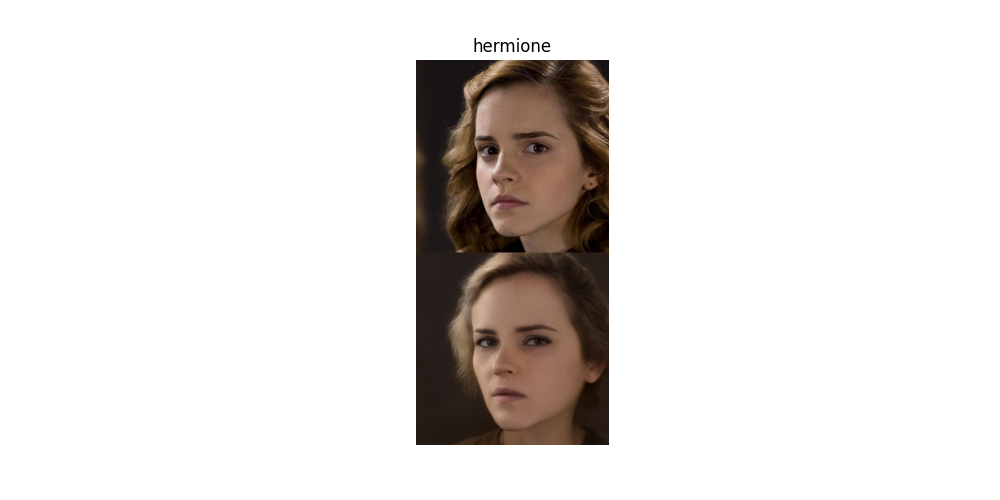

Парметры, давшие (визуально) лучшую проекцию:  {'learning_rate': 0.0048536614622611465, 'num_steps': 164, 'lpips_weight:': 4.280693922797875, 'rec_weight:': 2.031378741858841, 'noise_weight:': 0.5118172622800595}}

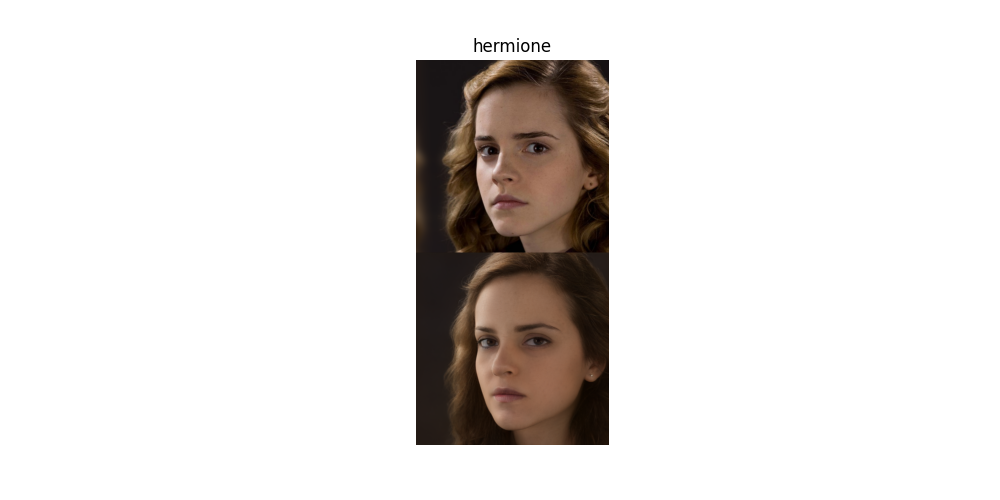

Видимо, при подборе гиперпараметров не стоило оптимизировать тот же лосс, что используется для обучения. Т.к. сам лосс напрямую зависит от этих гиперпараметров, сравнивать их не совсем корректно. В следующем эксперименте (с подменой лиц) попробую минимизировать MSE между генерацией и таргретом.

In [ ]:
selected_params = {
    "initial_learning_rate": 0.005,
    "num_steps": 164,
    "lpips_weight": 5,
    "rec_weight": 2,
    "regularize_noise_weight": 0.5,
}

In [ ]:
projections = {}
for character in CHARACTERS:
    image_path = os.path.join(ALIGNED_IMAGES_DIR, f"{character}/0.jpg")
    target_tensor, generated_tensor, loss = project(image_path, **selected_params)
    projection = torch.cat([target_tensor, generated_tensor], dim=2)
    projections.update({character: projection})
img_name = f"best_params_projections.png"
path = os.path.join(PROJ_DIR, img_name)
plt.title(str(selected_params))
plot_edits(projections).savefig(path, pad_inches=0, bbox_inches="tight")
plt.close()

# Encoder for editing

In [15]:
import torchvision.transforms as transforms
from stylegan2_models.e4e.model_utils import load_e4e_standalone

e4e_model, _ = load_e4e_standalone(
    "/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt"
)

image2e4etensor = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [ ]:
image_path = os.path.join(ALIGNED_IMAGES_DIR, "hermione/0.jpg")
target_pil = Image.open(image_path).convert("RGB")
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)
print(initial_latent_vector.size())

torch.Size([1, 18, 512])


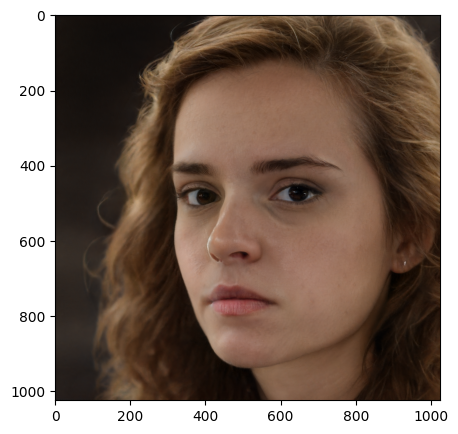

In [ ]:
generated_tensor = G.synthesis(
    initial_latent_vector, noise_mode="const", force_fp32=True
)
plot_image(generated_tensor, (5, 5))

In [73]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.decomposition import PCA

images_path = ALIGNED_IMAGES_DIR
E4E_DIR = "/content/e4e_invertion"

data = []
for persone in sorted(os.listdir(images_path)):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(E4E_DIR, persone)
    os.makedirs(save_folder, exist_ok=True)

    for image_name in os.listdir(person_images):
        image_path = os.path.join(person_images, image_name)

        target_pil = Image.open(image_path).convert("RGB")
        target_uint8 = np.array(target_pil, dtype=np.uint8)

        e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)

        latent_vector = e4e_model(e4e_tensor).detach().cpu()
        latent_path = os.path.join(save_folder, f"{image_name[:-4]}.pt")

        torch.save(latent_vector, latent_path)
        data.append([persone, image_name, image_path, latent_path])

df = pd.DataFrame(data, columns=["key", "image_name", "image_path", "latent_path"])

# Style & Expression Transfers

In [48]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"
%rm -rf /content/e4e_invertion

In [49]:
! mv /content/stylegan2-ada-pytorch/editing /content

mv: cannot stat '/content/stylegan2-ada-pytorch/editing': No such file or directory


In [50]:
import ipywidgets as widgets
import torch
from IPython.display import FileLink, display
from ipywidgets import fixed, interact, interact_manual, interactive


def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0, 18)]):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode="const", force_fp32=True)
    return edited_tensor

In [105]:
def get_refs_tensor(refs, get_e4e_path):
    tensors = []
    for ref in refs:
        path = get_e4e_path(ref)
        latent = torch.load(path).to(device)
        tensor = G.synthesis(latent, noise_mode="const", force_fp32=True)
        tensors.append(tensor)
    empty = torch.full_like(tensor, 255)
    tensors = [empty] + tensors
    return torch.cat(tensors, dim=2)

In [100]:
import os

STYLES = ["style_0", "style_1", "style_2"]


def transfer_styles(
    characters=CHARACTERS, num_imgs=1, psi=0.5, indeces=[i for i in range(6, 18)]
):
    get_styles_e4e_path = lambda style: os.path.join(E4E_DIR, style, "0.pt")
    transfers = {"styles": get_refs_tensor(STYLES, get_styles_e4e_path)}

    for character in characters:
        tensors = []
        ch_dir = os.path.join(E4E_DIR, character)
        for ch_fname in os.listdir(ch_dir)[:num_imgs]:
            ch_path = os.path.join(ch_dir, ch_fname)
            latent1 = torch.load(ch_path).to(device)
            init_tensor = G.synthesis(latent1, noise_mode="const", force_fp32=True)
            tensors.append(init_tensor)
            for style in STYLES:
                s_path = os.path.join(E4E_DIR, style, "0.pt")
                latent2 = torch.load(s_path).to(device)
                edited_tensor = interpolate(latent1, latent2, psi=psi, indeces=indeces)
                tensors.append(edited_tensor)
            transfers.update({f"{character}_{ch_fname}": torch.cat(tensors, dim=2)})
    return transfers

In [101]:
EXPRESSIONS = ["smile", "sad", "shout"]


def transfer_expressions(
    characters=CHARACTERS, num_imgs=1, psi=0.5, indeces=range(3, 6)
):
    expression_e4e_dir = os.path.join(E4E_DIR, "expressions")
    get_expr_e4e_path = lambda expression: os.path.join(
        expression_e4e_dir, f"{expression}.pt"
    )
    neutral_path = os.path.join(expression_e4e_dir, "neutral.pt")
    latent0 = torch.load(neutral_path).to(device)
    # latent0 = broadcast_w_sg(latent0)
    transfers = {"expressions": get_refs_tensor(EXPRESSIONS, get_expr_e4e_path)}

    for character in characters:
        tensors = []
        ch_dir = os.path.join(E4E_DIR, character)
        for ch_fname in os.listdir(ch_dir)[:num_imgs]:
            ch_path = os.path.join(ch_dir, ch_fname)
            latent1 = torch.load(ch_path).to(device)
            init_tensor = G.synthesis(latent1, noise_mode="const", force_fp32=True)
            tensors.append(init_tensor)
            for expression in EXPRESSIONS:
                exp_path = os.path.join(expression_e4e_dir, f"{expression}.pt")
                latent2 = torch.load(exp_path).to(device)
                dif = latent2 - latent0
                edited_tensor = interpolate(latent1, dif, psi=psi, indeces=indeces)
                tensors.append(edited_tensor)
            transfers.update({f"{character}_{ch_fname}": torch.cat(tensors, dim=2)})
    return transfers

In [99]:
def run_transfer_experiments(transfer_type, psi_range, min_idx_range, max_idx_range):
    TRANSFERS = {
        "styles": [transfer_styles, STYLES_DIR],
        "expression": [transfer_expressions, EXPRESSION_DIR],
    }
    transfer_fn, saving_dir = TRANSFERS[transfer_type]
    os.makedirs(saving_dir, exist_ok=True)
    for p in psi_range:
        for min_idx in min_idx_range:
            for max_idx in max_idx_range:
                max_idx += 1
                psi = round(0.1 * p, 1)
                indices = range(min_idx, max_idx)
                experiment = f'psi{str(psi).replace(".","")}_{min_idx}-{max_idx}.png'
                path = os.path.join(saving_dir, experiment)
                plot_edits(transfer_fn(psi=psi, indeces=indices)).savefig(
                    path, pad_inches=0, bbox_inches="tight"
                )
                plt.close()

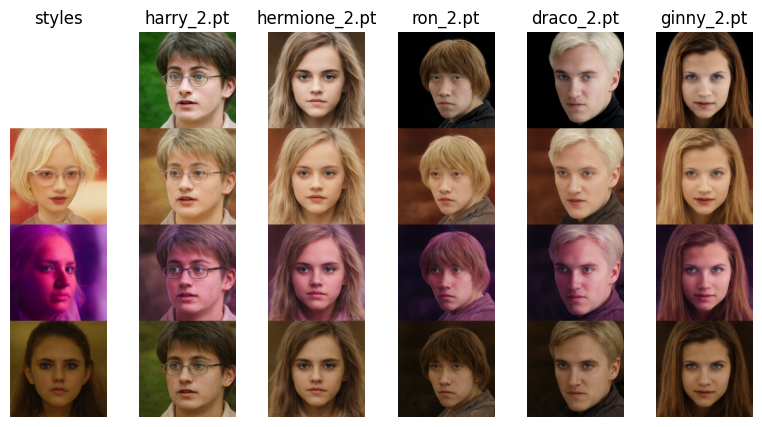

In [ ]:
plot_edits(transfer_styles());

In [ ]:
run_transfer_experiments(
    transfer_type="styles",
    psi_range=range(4, 10),
    min_idx_range=range(6, 10),
    max_idx_range=range(17, 18),
)

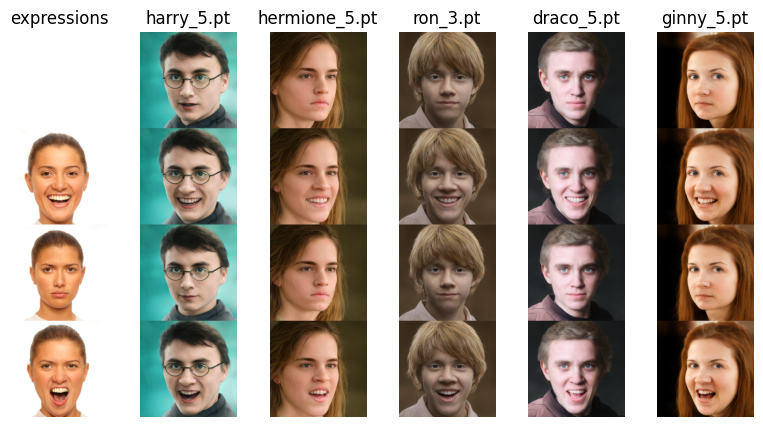

In [106]:
plot_edits(transfer_expressions());

In [109]:
run_transfer_experiments(
    transfer_type="expression",
    psi_range=range(4, 7),
    min_idx_range=range(2, 4),
    max_idx_range=range(4, 6),
)

# Face swaps

In [16]:
file_id = "1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5"  # URL id.
downloaded = drive.CreateFile({"id": file_id})
downloaded.GetContentFile("ms1mv3_arcface_r50_fp16.pth")

In [17]:
import os

import lpips
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
from stylegan2_models.e4e.model_utils import load_e4e_standalone


def image2tensor_norm(image):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    )
    tensor = transform(image)
    return tensor


class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):
        source = F.interpolate(source, size=(112, 112), mode="bicubic")
        synth = F.interpolate(synth, size=(112, 112), mode="bicubic")

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

In [18]:
arcface_path = "/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
arcface = Arcface_Loss(arcface_path, "cuda")

In [19]:
import gc


def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

In [20]:
import torch.nn as nn
from tqdm import tqdm


def face_swap(
    character1,
    character2,
    regularize_noise_weight=1,
    num_steps=100,
    seed=42,
    arcface_weight=1,
    rec_weight=1,
    lpips_weight=1,
    learning_rate=5e-2,
):
    ch_path1 = os.path.join(ALIGNED_IMAGES_DIR, character1, "0.jpg")
    target1_pil = Image.open(ch_path1).convert("RGB")
    target1_uint8 = np.array(target1_pil, dtype=np.uint8)
    target1_tensor = image2tensor_norm(target1_pil).to(device).unsqueeze(0)
    e4e_tensor1 = image2e4etensor(target1_uint8).to(device).unsqueeze(0)
    latent1 = e4e_model(e4e_tensor1)

    ch_path2 = os.path.join(ALIGNED_IMAGES_DIR, character2, "0.jpg")
    target2_pil = Image.open(ch_path2).convert("RGB")
    target2_uint8 = np.array(target2_pil, dtype=np.uint8)
    target2_tensor = image2tensor_norm(target2_pil).to(device).unsqueeze(0)

    initial_latent_vector = nn.Parameter(latent1, requires_grad=True)

    optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=range(100, 500, 100), gamma=0.1
    )
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(initial_latent_vector, noise_mode="const")
        lpips_value = lpips_loss(synth_tensor, target1_tensor)
        rec_value = rec_loss(synth_tensor, target1_tensor)
        reg_value = reg_loss()

        arcface_value = arcface(synth_tensor, target2_tensor)
        loss = (
            arcface_value * arcface_weight
            + reg_value * regularize_noise_weight
            + lpips_value
            + lpips_value * lpips_weight
            + rec_value * rec_weight
        )

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        generated_tensors.append(synth_tensor.cpu())
        cleanup()

    generated_tensor = G.synthesis(
        initial_latent_vector, noise_mode="const", force_fp32=True
    )
    generated_tensor.to("cpu")
    target2_tensor.to("cpu")
    mse = ((target2_tensor - generated_tensor) ** 2).sum().item()
    target1_tensor.to("cpu")
    cleanup()
    return generated_tensor, mse

In [21]:
import numpy as np


def get_face_initial_tensor(characters):
    tensors = []
    for character1 in characters:
        ch_path = os.path.join(ALIGNED_IMAGES_DIR, character1, "0.jpg")
        ch_pil = Image.open(ch_path).convert("RGB")
        tensor = image2tensor_norm(ch_pil).unsqueeze(0)
        tensors.append(tensor)
    empty = torch.full_like(tensor, 255)
    tensors = [empty] + tensors
    return torch.cat(tensors, dim=2)


def swap_faces(source_characters=CHARACTERS, target_characters=CHARACTERS, **params):
    mse_losses = []
    swaps = {"target": get_face_initial_tensor(target_characters)}
    for character1 in source_characters:
        ch_path1 = os.path.join(ALIGNED_IMAGES_DIR, character1, "0.jpg")
        ch_pil = Image.open(ch_path1).convert("RGB")
        tensor = image2tensor_norm(ch_pil).unsqueeze(0)
        tensors = [tensor.cpu()]
        for character2 in target_characters:
            print(f"{character1} -> {character2}")
            generated_tensor, mse = face_swap(character1, character2, **params)
            tensors.append(generated_tensor.cpu())
            mse_losses.append(mse)
        swaps.update({character1: torch.cat(tensors, dim=2)})
    return swaps, np.mean(mse_losses)

In [ ]:
import wandb

PROJECT = "deep-gen-hw3-faceswap"


def stylegan_projection_objective(trial):
    source_characters = ["harry"]
    target_characters = ["draco"]
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 5e-2, log=True)
    num_steps = trial.suggest_int("num_steps", 50, 300)
    arcface_weight = trial.suggest_float("arface_weight:", 0.5, 10)
    lpips_weight = trial.suggest_float("lpips_weight:", 0.5, 2)
    rec_weight = trial.suggest_float("rec_weight:", 0.5, 2)
    regularize_noise_weight = trial.suggest_float("noise_weight:", 5e-5, 5e5, log=True)

    wandb.init(project=PROJECT, config={**trial.params})
    projections = {}
    swaps, mse_loss = swap_faces(
        source_characters,
        target_characters,
        arcface_weight=arcface_weight,
        lpips_weight=lpips_weight,
        rec_weight=rec_weight,
        regularize_noise_weight=regularize_noise_weight,
        num_steps=num_steps,
        learning_rate=learning_rate,
    )
    result = plot_edits(swaps)
    plt.close()
    wandb.log({"mse_loss": mse_loss, "image": wandb.Image(result)})
    wandb.finish()
    return mse_loss

In [ ]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)
study = optuna.create_study(
    study_name="face-swapping", direction="minimize", sampler=sampler
)
study.optimize(stylegan_projection_objective, n_trials=30)

[I 2024-03-26 20:30:16,081] A new study created in memory with name: face-swapping


100%|██████████| 230/230 [03:52<00:00,  1.01s/it]


mse_loss,▁
mse_loss,2149510.5


[I 2024-03-26 20:34:23,930] Trial 0 finished with value: 2149510.5 and parameters: {'learning_rate': 0.005111023492152639, 'num_steps': 230, 'arface_weight:': 0.5001713475190673, 'lpips_weight:': 0.7603128847689651, 'rec_weight:': 0.612810015621745, 'noise_weight:': 0.0004191369531411085}. Best is trial 0 with value: 2149510.5.
wandb: Currently logged in as: missmarshal22. Use `wandb login --relogin` to force relogin


100%|██████████| 136/136 [02:21<00:00,  1.04s/it]


mse_loss,▁
mse_loss,2251730.5


[I 2024-03-26 20:36:56,381] Trial 1 finished with value: 2251730.5 and parameters: {'learning_rate': 0.002072289908636552, 'num_steps': 136, 'arface_weight:': 1.6412562375078097, 'lpips_weight:': 1.0552855770718363, 'rec_weight:': 0.8940262077959862, 'noise_weight:': 355.76646481756757}. Best is trial 0 with value: 2149510.5.


100%|██████████| 270/270 [04:35<00:00,  1.02s/it]


mse_loss,▁
mse_loss,2169702.0


[I 2024-03-26 20:41:43,853] Trial 2 finished with value: 2169702.0 and parameters: {'learning_rate': 0.002225144604874549, 'num_steps': 270, 'arface_weight:': 0.5427528149811441, 'lpips_weight:': 1.2665772052229984, 'rec_weight:': 0.8916871949867126, 'noise_weight:': 19.31382485729017}. Best is trial 0 with value: 2149510.5.


100%|██████████| 99/99 [01:42<00:00,  1.03s/it]


mse_loss,▁
mse_loss,2211481.75


[I 2024-03-26 20:43:37,281] Trial 3 finished with value: 2211481.75 and parameters: {'learning_rate': 0.0017318616590910683, 'num_steps': 99, 'arface_weight:': 5.505068243264415, 'lpips_weight:': 1.9139102142953337, 'rec_weight:': 0.7720939729554994, 'noise_weight:': 418.98276745833124}. Best is trial 0 with value: 2149510.5.


100%|██████████| 274/274 [04:42<00:00,  1.03s/it]


mse_loss,▁
mse_loss,2105046.5


[I 2024-03-26 20:48:33,019] Trial 4 finished with value: 2105046.5 and parameters: {'learning_rate': 0.030828960540656064, 'num_steps': 274, 'arface_weight:': 0.6450822235876692, 'lpips_weight:': 0.527816942717099, 'rec_weight:': 0.6327295321251563, 'noise_weight:': 30226.99948588964}. Best is trial 4 with value: 2105046.5.


100%|██████████| 155/155 [02:41<00:00,  1.04s/it]


mse_loss,▁
mse_loss,2272420.5


[I 2024-03-26 20:51:25,632] Trial 5 finished with value: 2272420.5 and parameters: {'learning_rate': 0.0014692250375888643, 'num_steps': 155, 'arface_weight:': 8.8148112161166, 'lpips_weight:': 1.0470501688923235, 'rec_weight:': 1.3047326594085724, 'noise_weight:': 0.07147041673033674}. Best is trial 4 with value: 2105046.5.


100%|██████████| 259/259 [04:29<00:00,  1.04s/it]


mse_loss,▁
mse_loss,2157725.25


[I 2024-03-26 20:56:07,045] Trial 6 finished with value: 2157725.25 and parameters: {'learning_rate': 0.014667107803924226, 'num_steps': 259, 'arface_weight:': 0.5281576829592456, 'lpips_weight:': 1.4144965224771313, 'rec_weight:': 1.9693536075687426, 'noise_weight:': 1515.746409440425}. Best is trial 4 with value: 2105046.5.


100%|██████████| 248/248 [04:18<00:00,  1.04s/it]


mse_loss,▁
mse_loss,2159020.0


[I 2024-03-26 21:00:36,659] Trial 7 finished with value: 2159020.0 and parameters: {'learning_rate': 0.002995476593698437, 'num_steps': 248, 'arface_weight:': 0.6811929353171542, 'lpips_weight:': 0.9303123296894344, 'rec_weight:': 1.7619720098002583, 'noise_weight:': 0.043162986664405385}. Best is trial 4 with value: 2105046.5.


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


mse_loss,▁
mse_loss,2172440.0


[I 2024-03-26 21:02:13,099] Trial 8 finished with value: 2172440.0 and parameters: {'learning_rate': 0.0030826318995701087, 'num_steps': 82, 'arface_weight:': 0.5298671523348889, 'lpips_weight:': 1.2813557420536092, 'rec_weight:': 0.6704753659913812, 'noise_weight:': 0.02261708332563457}. Best is trial 4 with value: 2105046.5.


100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


mse_loss,▁
mse_loss,2174878.5


[I 2024-03-26 21:03:29,525] Trial 9 finished with value: 2174878.5 and parameters: {'learning_rate': 0.006841763417310985, 'num_steps': 63, 'arface_weight:': 2.791992389375443, 'lpips_weight:': 0.6127868102365212, 'rec_weight:': 1.1317937485194227, 'noise_weight:': 497.2257420273849}. Best is trial 4 with value: 2105046.5.


100%|██████████| 204/204 [03:33<00:00,  1.05s/it]


mse_loss,▁
mse_loss,2137494.0


[I 2024-03-26 21:07:15,030] Trial 10 finished with value: 2137494.0 and parameters: {'learning_rate': 0.048679291112081864, 'num_steps': 204, 'arface_weight:': 1.1793239874082313, 'lpips_weight:': 0.5280055526089887, 'rec_weight:': 0.5070474332313806, 'noise_weight:': 345806.98001352086}. Best is trial 4 with value: 2105046.5.


100%|██████████| 204/204 [03:33<00:00,  1.05s/it]


mse_loss,▁
mse_loss,2084112.5


[I 2024-03-26 21:11:00,455] Trial 11 finished with value: 2084112.5 and parameters: {'learning_rate': 0.035393938101191486, 'num_steps': 204, 'arface_weight:': 1.1151381000854972, 'lpips_weight:': 0.5129630536779264, 'rec_weight:': 0.5129367989912479, 'noise_weight:': 261943.99686287518}. Best is trial 11 with value: 2084112.5.


100%|██████████| 299/299 [05:17<00:00,  1.06s/it]


mse_loss,▁
mse_loss,2120634.0


[I 2024-03-26 21:16:30,137] Trial 12 finished with value: 2120634.0 and parameters: {'learning_rate': 0.03835160206234172, 'num_steps': 299, 'arface_weight:': 0.9940850551452787, 'lpips_weight:': 0.5020645570473026, 'rec_weight:': 0.5104487769964297, 'noise_weight:': 449672.3601065652}. Best is trial 11 with value: 2084112.5.


100%|██████████| 193/193 [03:24<00:00,  1.06s/it]


mse_loss,▁
mse_loss,1998106.75


[I 2024-03-26 21:20:05,570] Trial 13 finished with value: 1998106.75 and parameters: {'learning_rate': 0.01761809507380524, 'num_steps': 193, 'arface_weight:': 2.4225015392969427, 'lpips_weight:': 0.682967199143992, 'rec_weight:': 0.6506067013473381, 'noise_weight:': 35151.87714731071}. Best is trial 13 with value: 1998106.75.


100%|██████████| 186/186 [03:19<00:00,  1.07s/it]


mse_loss,▁
mse_loss,2144611.0


[I 2024-03-26 21:23:37,190] Trial 14 finished with value: 2144611.0 and parameters: {'learning_rate': 0.016620659490140372, 'num_steps': 186, 'arface_weight:': 2.825021997756719, 'lpips_weight:': 0.7014497830456423, 'rec_weight:': 0.717232663655367, 'noise_weight:': 18424.171251634252}. Best is trial 13 with value: 1998106.75.


100%|██████████| 210/210 [03:46<00:00,  1.08s/it]


mse_loss,▁
mse_loss,2080106.75


[I 2024-03-26 21:27:34,801] Trial 15 finished with value: 2080106.75 and parameters: {'learning_rate': 0.017911350412326842, 'num_steps': 210, 'arface_weight:': 1.9750658655324198, 'lpips_weight:': 0.7015322952269347, 'rec_weight:': 0.5521417303398638, 'noise_weight:': 5.271794821902345}. Best is trial 13 with value: 1998106.75.


100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


mse_loss,▁
mse_loss,2141775.0


[I 2024-03-26 21:30:02,206] Trial 16 finished with value: 2141775.0 and parameters: {'learning_rate': 0.012626405403246416, 'num_steps': 126, 'arface_weight:': 4.022806142302737, 'lpips_weight:': 0.8143664837310244, 'rec_weight:': 0.8409999313735407, 'noise_weight:': 2.0831619253797036}. Best is trial 13 with value: 1998106.75.


100%|██████████| 171/171 [03:02<00:00,  1.07s/it]


mse_loss,▁
mse_loss,2114392.5


[I 2024-03-26 21:33:15,670] Trial 17 finished with value: 2114392.5 and parameters: {'learning_rate': 0.024849733677370197, 'num_steps': 171, 'arface_weight:': 1.8158144101731046, 'lpips_weight:': 0.6486549003916742, 'rec_weight:': 0.5963713181983193, 'noise_weight:': 6.155729706657577}. Best is trial 13 with value: 1998106.75.


100%|██████████| 221/221 [03:59<00:00,  1.08s/it]


mse_loss,▁
mse_loss,2001977.75


[I 2024-03-26 21:37:25,349] Trial 18 finished with value: 2001977.75 and parameters: {'learning_rate': 0.0097825533154651, 'num_steps': 221, 'arface_weight:': 4.721839884507358, 'lpips_weight:': 0.7960602330054362, 'rec_weight:': 1.0582549441561986, 'noise_weight:': 5.562948736113467e-05}. Best is trial 13 with value: 1998106.75.


100%|██████████| 237/237 [04:20<00:00,  1.10s/it]


mse_loss,▁
mse_loss,2225797.5


[I 2024-03-26 21:41:56,863] Trial 19 finished with value: 2225797.5 and parameters: {'learning_rate': 0.008688378174329924, 'num_steps': 237, 'arface_weight:': 5.33093906152132, 'lpips_weight:': 0.880093375727791, 'rec_weight:': 1.1099749498523024, 'noise_weight:': 0.00041222122130258086}. Best is trial 13 with value: 1998106.75.


100%|██████████| 162/162 [02:57<00:00,  1.10s/it]


mse_loss,▁
mse_loss,2218011.0


[I 2024-03-26 21:45:06,425] Trial 20 finished with value: 2218011.0 and parameters: {'learning_rate': 0.001004753342941735, 'num_steps': 162, 'arface_weight:': 9.44955792496854, 'lpips_weight:': 0.6292634139752176, 'rec_weight:': 1.3226994451752248, 'noise_weight:': 7.634595141389304e-05}. Best is trial 13 with value: 1998106.75.


100%|██████████| 215/215 [03:57<00:00,  1.10s/it]


mse_loss,▁
mse_loss,1991867.875


[I 2024-03-26 21:49:15,920] Trial 21 finished with value: 1991867.875 and parameters: {'learning_rate': 0.021461541641212372, 'num_steps': 215, 'arface_weight:': 3.190351768885961, 'lpips_weight:': 0.7498504179145963, 'rec_weight:': 0.9868064639867378, 'noise_weight:': 0.509646862816658}. Best is trial 21 with value: 1991867.875.


100%|██████████| 187/187 [03:27<00:00,  1.11s/it]


mse_loss,▁
mse_loss,2134934.75


[I 2024-03-26 21:52:55,602] Trial 22 finished with value: 2134934.75 and parameters: {'learning_rate': 0.009563556017507724, 'num_steps': 187, 'arface_weight:': 3.5393455523799777, 'lpips_weight:': 0.8444760713976749, 'rec_weight:': 0.9910539559427157, 'noise_weight:': 0.42478132925656886}. Best is trial 21 with value: 1991867.875.


100%|██████████| 226/226 [04:10<00:00,  1.11s/it]


mse_loss,▁
mse_loss,1933364.125


[I 2024-03-26 21:57:17,054] Trial 23 finished with value: 1933364.125 and parameters: {'learning_rate': 0.022180670580978192, 'num_steps': 226, 'arface_weight:': 6.267093176419833, 'lpips_weight:': 0.9845424180521374, 'rec_weight:': 1.4381665996769506, 'noise_weight:': 0.0022843116749415304}. Best is trial 23 with value: 1933364.125.


100%|██████████| 192/192 [03:34<00:00,  1.12s/it]


mse_loss,▁
mse_loss,1932409.625


[I 2024-03-26 22:01:02,745] Trial 24 finished with value: 1932409.625 and parameters: {'learning_rate': 0.02365513380628162, 'num_steps': 192, 'arface_weight:': 6.7028629670798106, 'lpips_weight:': 0.9706249372633694, 'rec_weight:': 1.5328794346072616, 'noise_weight:': 0.002343799759443368}. Best is trial 24 with value: 1932409.625.


100%|██████████| 143/143 [02:39<00:00,  1.12s/it]


mse_loss,▁
mse_loss,2159745.0


[I 2024-03-26 22:03:54,114] Trial 25 finished with value: 2159745.0 and parameters: {'learning_rate': 0.024797478904024756, 'num_steps': 143, 'arface_weight:': 6.625865114192873, 'lpips_weight:': 1.1716717696598513, 'rec_weight:': 1.5028446963596485, 'noise_weight:': 0.0042666820600499285}. Best is trial 24 with value: 1932409.625.


100%|██████████| 221/221 [04:07<00:00,  1.12s/it]


mse_loss,▁
mse_loss,1979314.125


[I 2024-03-26 22:08:13,642] Trial 26 finished with value: 1979314.125 and parameters: {'learning_rate': 0.022812929330374817, 'num_steps': 221, 'arface_weight:': 7.8053278579457555, 'lpips_weight:': 0.9939631873597111, 'rec_weight:': 1.5941906070547944, 'noise_weight:': 0.0031556895094819104}. Best is trial 24 with value: 1932409.625.


100%|██████████| 242/242 [04:31<00:00,  1.12s/it]


mse_loss,▁
mse_loss,1808169.5


[I 2024-03-26 22:12:57,129] Trial 27 finished with value: 1808169.5 and parameters: {'learning_rate': 0.04605856026374361, 'num_steps': 242, 'arface_weight:': 7.520591173822019, 'lpips_weight:': 1.578519647128322, 'rec_weight:': 1.5845427716263278, 'noise_weight:': 0.0030556791566100573}. Best is trial 27 with value: 1808169.5.


100%|██████████| 283/283 [05:19<00:00,  1.13s/it]


mse_loss,▁
mse_loss,1581052.375


[I 2024-03-26 22:18:26,762] Trial 28 finished with value: 1581052.375 and parameters: {'learning_rate': 0.04899680678754926, 'num_steps': 283, 'arface_weight:': 6.811273771261506, 'lpips_weight:': 1.6221065597788114, 'rec_weight:': 1.330028243832107, 'noise_weight:': 0.002048252128132912}. Best is trial 28 with value: 1581052.375.


100%|██████████| 299/299 [05:37<00:00,  1.13s/it]


mse_loss,▁
mse_loss,1895342.375


[I 2024-03-26 22:24:14,327] Trial 29 finished with value: 1895342.375 and parameters: {'learning_rate': 0.047436199835143265, 'num_steps': 299, 'arface_weight:': 7.69248599763414, 'lpips_weight:': 1.6535191685278652, 'rec_weight:': 1.245923361030546, 'noise_weight:': 0.0004225904629178183}. Best is trial 28 with value: 1581052.375.


Параметры, давшие наименьший лосс: {'learning_rate': 0.04899680678754926, 'num_steps': 283, 'arface_weight:': 6.811273771261506, 'lpips_weight:': 1.6221065597788114, 'rec_weight:': 1.330028243832107, 'noise_weight:': 0.002048252128132912}.



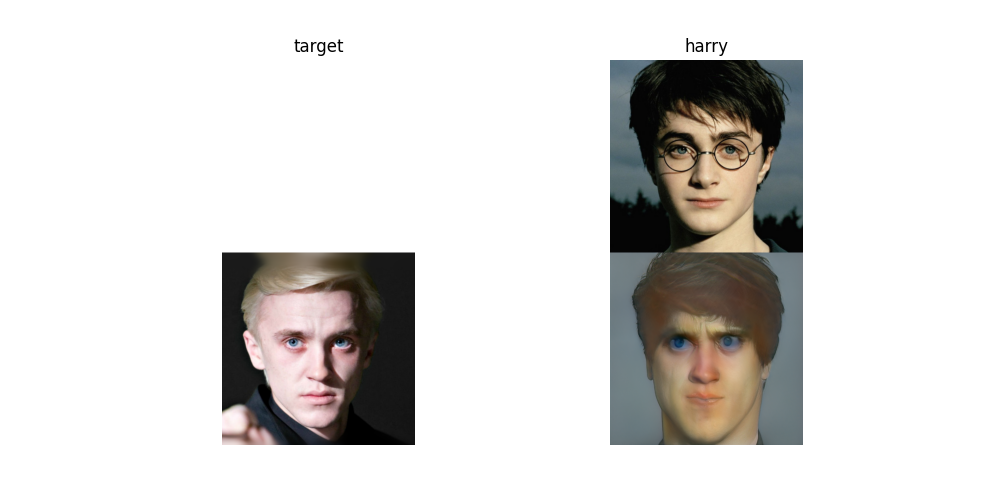

Парметры, давшие (визуально) лучший результат: {'learning_rate': 0.030828960540656064, 'num_steps': 274, 'arface_weight:': 0.6450822235876692, 'lpips_weight:': 0.527816942717099, 'rec_weight:': 0.6327295321251563, 'noise_weight:': 30226.99948588964}


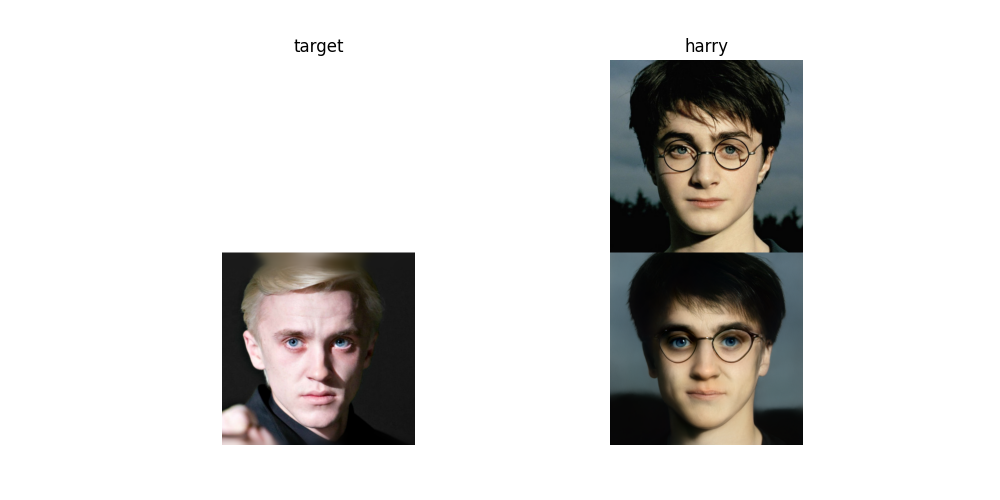


Минимизация MSE между таргетом и генерацией тоже оказалась не лучшим выбором. Наименьшие значения лосса получают генерации с большим весом arcface, но при этом они выглядят не реалистично.

In [22]:
selected_params = {
    "learning_rate": 0.03,
    "num_steps": 274,
    "arcface_weight": 0.65,
    "lpips_weight": 0.5,
    "rec_weight": 0.6,
    "regularize_noise_weight": 30226,
}

In [23]:
for character in CHARACTERS[2:]:
    swaps, _ = swap_faces(
        source_characters=[character], target_characters=CHARACTERS, **selected_params
    )
    img_name = f"{character}_best_params_projections.png"
    path = os.path.join(FACE_SWAP_DIR, img_name)
    fig = plot_edits(swaps).set_figwidth(2)
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    cleanup()

ron -> harry


  0%|          | 0/274 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|██████████| 274/274 [04:19<00:00,  1.05it/s]


ron -> hermione


100%|██████████| 274/274 [04:21<00:00,  1.05it/s]


ron -> ron


100%|██████████| 274/274 [04:21<00:00,  1.05it/s]


ron -> draco


100%|██████████| 274/274 [04:21<00:00,  1.05it/s]


ron -> ginny


100%|██████████| 274/274 [04:22<00:00,  1.04it/s]


draco -> harry


100%|██████████| 274/274 [04:23<00:00,  1.04it/s]


draco -> hermione


100%|██████████| 274/274 [04:24<00:00,  1.04it/s]


draco -> ron


100%|██████████| 274/274 [04:25<00:00,  1.03it/s]


draco -> draco


100%|██████████| 274/274 [04:26<00:00,  1.03it/s]


draco -> ginny


100%|██████████| 274/274 [04:24<00:00,  1.04it/s]


ginny -> harry


100%|██████████| 274/274 [04:18<00:00,  1.06it/s]


ginny -> hermione


100%|██████████| 274/274 [04:20<00:00,  1.05it/s]


ginny -> ron


100%|██████████| 274/274 [04:22<00:00,  1.04it/s]


ginny -> draco


100%|██████████| 274/274 [04:24<00:00,  1.04it/s]


ginny -> ginny


100%|██████████| 274/274 [04:30<00:00,  1.01it/s]
